# Laboratoire 7
## Lidar, ICP et mapping

Ce laboratoire consiste à vous familiariser avec l'utilisation et le comportement de l'algorithme *Iterative Closest Point*. L'idée est d'aligner des scans lasers consécutifs de façon à construire une carte 2D de l'environnement. Notez qu'il ne s'agit pas ici de faire du SLAM, mais bien de simplement aligner des scans consécutifs sans faire de vérification ou ajustement par la suite.

![Le lidar Hokuyo](img/hokuyo.jpg)

Le scanner Hokuyo URG-04LX-UG01 possède un champ de vision horizontal de 270 degrés et une portée de 0.02 à 5.6 m. Placez les obstacles à l'intérieur de cette zone pendant la création de votre carte!

### Partie 1 - Afficher un scan

D'abord la poutine préliminaire habituelle.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib nbagg

import time
import numpy as np
import matplotlib.pyplot as plt

from robmob.icp import icp
from robmob.robot import Robot
from robmob.sensors import HokuyoSensor

In [2]:
robot = Robot('192.168.0.108')
robot.connect()

In [3]:
hokuyo = HokuyoSensor()
robot.add_sensor(hokuyo)

La fonction `hokuyo_to_3d_homogeneous_matrix` accepte un scan du Hokuyo et le transforme en une matrice Nx4 de points 3D (en coordonnées homogènes). Elle fait simplement la conversion de coordonnées polaires à cartésiennes. Comme le Hokuyo est un scanneur 2D, la fonction fixe simplement la coordonnée en $z$ comme étant égale à 0.

In [6]:
def hokuyo_to_3d_homogeneous_matrix(hokuyo_data):
    ranges = np.array(hokuyo_data['ranges'])
    thetas = np.arange(hokuyo_data['angle_min'], hokuyo_data['angle_max']+hokuyo_data['angle_increment'], hokuyo_data['angle_increment'])
    xs = ranges * np.cos(thetas)
    ys = ranges * np.sin(thetas)
    
    pts = np.vstack((xs, ys, np.zeros(xs.shape), np.ones(xs.shape))).T
    
    # Remove the points that are at the origin.
    pts = pts[np.nonzero(np.logical_or(pts[:,0] != 0., pts[:,1] != 0.))]
    
    return pts

In [11]:
pointcloud = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())
pointcloud

array([[ -2.31233246e-08,  -5.28999984e-01,   0.00000000e+00,
          1.00000000e+00],
       [  2.73044925e-03,  -4.44991616e-01,   0.00000000e+00,
          1.00000000e+00],
       [  5.52217257e-03,  -4.49966104e-01,   0.00000000e+00,
          1.00000000e+00],
       ..., 
       [  1.05101659e-01,   1.22048298e+00,   0.00000000e+00,
          1.00000000e+00],
       [  3.36116256e-02,   2.73879384e+00,   0.00000000e+00,
          1.00000000e+00],
       [  1.67876616e-02,   2.73594856e+00,   0.00000000e+00,
          1.00000000e+00]])

La fonction `plot_point_clouds` accepte *une liste* de ces matrices et les trace sur un graphique. Le graphique est dans le repère de coordonnées du lidar, ce qui veux dire que les $x$ positifs pointent vers l'arrière du robot.

In [13]:
def plot_point_clouds(pcls):
    STYLES = ['r+', 'bx', 'g*']
    
    for i, pcl in enumerate(pcls):
        plt.plot(pcl[:,0], pcl[:,1], STYLES[i])
        plt.plot([0.0], [0.0], 'ko', markersize=10)
        
    plt.axis('equal')
    
    plt.show()

<IPython.core.display.Javascript object>


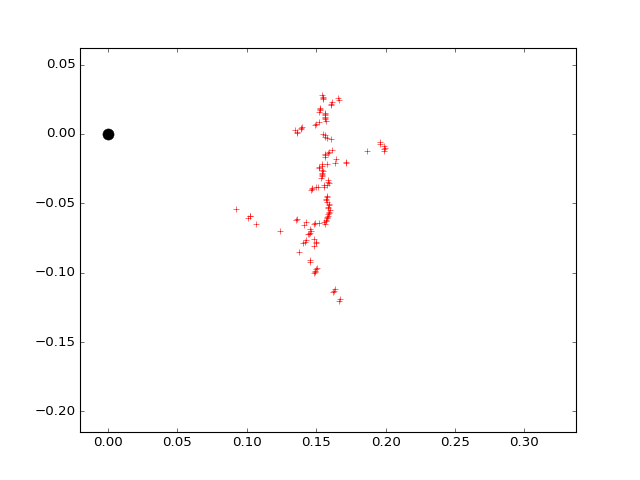

In [14]:
plot_point_clouds([pointcloud])

### Utiliser ICP

Nous avons une implémentation (un peu primitive) de l'algorithme ICP dans la librairie `robmob`. Pour l'utiliser, il faut appeler la fonction `icp`. Elle prend deux nuages de points en arguments et retourne une transformation homogène `H` qui exprime la position du premier nuage de point dans le repère de coordonnées du second. 

`icp` retourne aussi `err`, un vecteur qui donne la distance entre chaque paire de points associés. Ce vecteur est utile pour savoir si l'algorithme `icp` a bien convergé ou bien si le résultat laisse à désirer.

Pour tester l'algorithme, déplacez le robot et capturez un autre scan.

In [15]:
pcl1 = pointcloud
pcl2 = hokuyo_to_3d_homogeneous_matrix(hokuyo.peek_data())

In [16]:
H, err = icp(pcl1, pcl2)

In [17]:
H

array([[ 0.98932613,  0.14571827,  0.        , -0.1901141 ],
       [-0.14571827,  0.98932613,  0.        ,  0.0611905 ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [21]:
print('La distance moyenne entre les points associés est de {} m'.format(np.average(err)))

La distance moyenne entre les points associés est de 0.3904267492203068 m


Avec la matrice H en main, il est possible de déplacer le nuage `pcl1` de sorte qu'il soit dans le repère de coordonnées de `pcl2`. Complétez la fonction `apply_transformation_to_pcl`. 

In [23]:
def pcl_with_transformation_applied(H, pcl):
    '''
    Apply an homogeneous transformation to a pointcloud.
    Input
        H: A 4x4 matrix describing an homogeneous geometric transformation.
        pcl: A Nx4 matrix containing the points to be displaced.
    Output
        transformed_pcl: A Nx4 matrix contaning the displaced points.
    '''
    return (H.dot(pcl1.T)).T

L'appel suivant va tracer les deux nuages de points originaux, ainsi que le nuage de points déplacé.

<IPython.core.display.Javascript object>


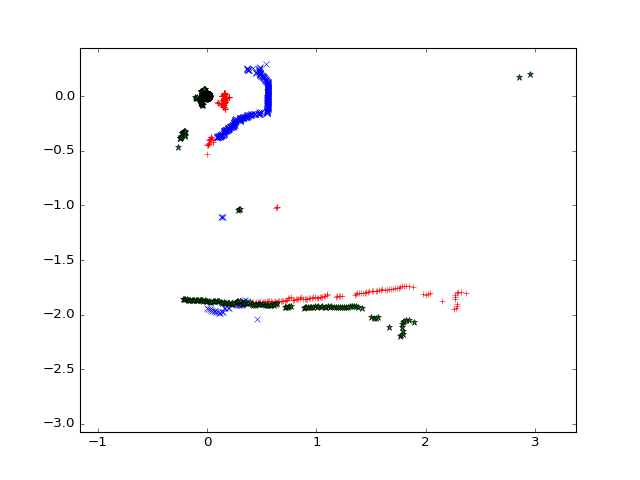

In [24]:
plot_point_clouds([pcl1, pcl2, pcl_with_transformation_applied(H, pcl1)])